## Imports

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, RNN, Conv1D
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams.update({'figure.figsize': (16, 9)})
import matplotlib
import sklearn
import keras

In [75]:
np.__version__, pd.__version__, matplotlib.__version__, sns.__version__, tf.__version__, sklearn.__version__, keras.__version__

('1.19.5', '1.2.4', '3.3.4', '0.11.1', '2.3.0', '0.24.2', '2.4.3')

## Load data

In [51]:
data = pd.read_csv('../data/processed/company_id_5_processed.csv', parse_dates=True)
data = data[['txn_date', 'open', 'high', 'low', 'close','vol', 
#              'month', 'day', 'day_of_month'
            ]].sort_values(by='txn_date')
data.head()

,txn_date,open,high,low,close,vol
0,2010-09-20,13.0,13.1,12.5,12.6,10323500.0
1,2010-09-21,12.8,13.2,12.7,12.9,3327500.0
2,2010-09-22,13.0,13.4,12.9,13.0,2765500.0
3,2010-09-23,13.3,13.4,13.0,13.0,2329000.0
4,2010-09-26,13.0,13.2,12.8,12.8,1608500.0


## Preprocessing

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 0 to 2117
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   txn_date  2552 non-null   object 
 1   open      2552 non-null   float64
 2   high      2552 non-null   float64
 3   low       2552 non-null   float64
 4   close     2552 non-null   float64
 5   vol       2552 non-null   float64
dtypes: float64(5), object(1)
memory usage: 139.6+ KB


In [53]:
data.describe()

,open,high,low,close,vol
count,2552.000000,2552.000000,2552.000000,2552.000000,2.552000e+03
mean,6.181113,6.306740,6.079428,6.165752,6.241883e+05
std,1.678561,1.725021,1.619739,1.651872,1.158548e+06
min,3.900000,4.000000,3.900000,3.900000,1.000000e+00
25%,4.800000,4.900000,4.700000,4.800000,1.083750e+05
50%,6.100000,6.200000,6.000000,6.000000,2.490030e+05
75%,7.000000,7.200000,6.900000,7.000000,6.220142e+05
max,13.300000,13.900000,13.000000,13.000000,1.610617e+07


In [54]:
data['txn_date'] = pd.to_datetime(data['txn_date'])
data.set_index('txn_date', inplace=True, drop=True)

In [55]:
data['close_roc'] = data['close'].pct_change()
data['close_log_roc'] = np.log(1+data['close_roc'])

In [56]:
data.dropna(inplace=True)
data.head()

,open,high,low,close,vol,close_roc,close_log_roc
txn_date,,,,,,,
2010-09-21,12.8,13.2,12.7,12.9,3327500.0,0.023810,0.023530
2010-09-22,13.0,13.4,12.9,13.0,2765500.0,0.007752,0.007722
2010-09-23,13.3,13.4,13.0,13.0,2329000.0,0.000000,0.000000
2010-09-26,13.0,13.2,12.8,12.8,1608500.0,-0.015385,-0.015504
2010-09-27,12.7,13.0,12.6,12.6,1332000.0,-0.015625,-0.015748


In [57]:
min(data.index), max(data.index), data.shape[0]

(Timestamp('2010-09-21 00:00:00'), Timestamp('2021-07-29 00:00:00'), 2551)

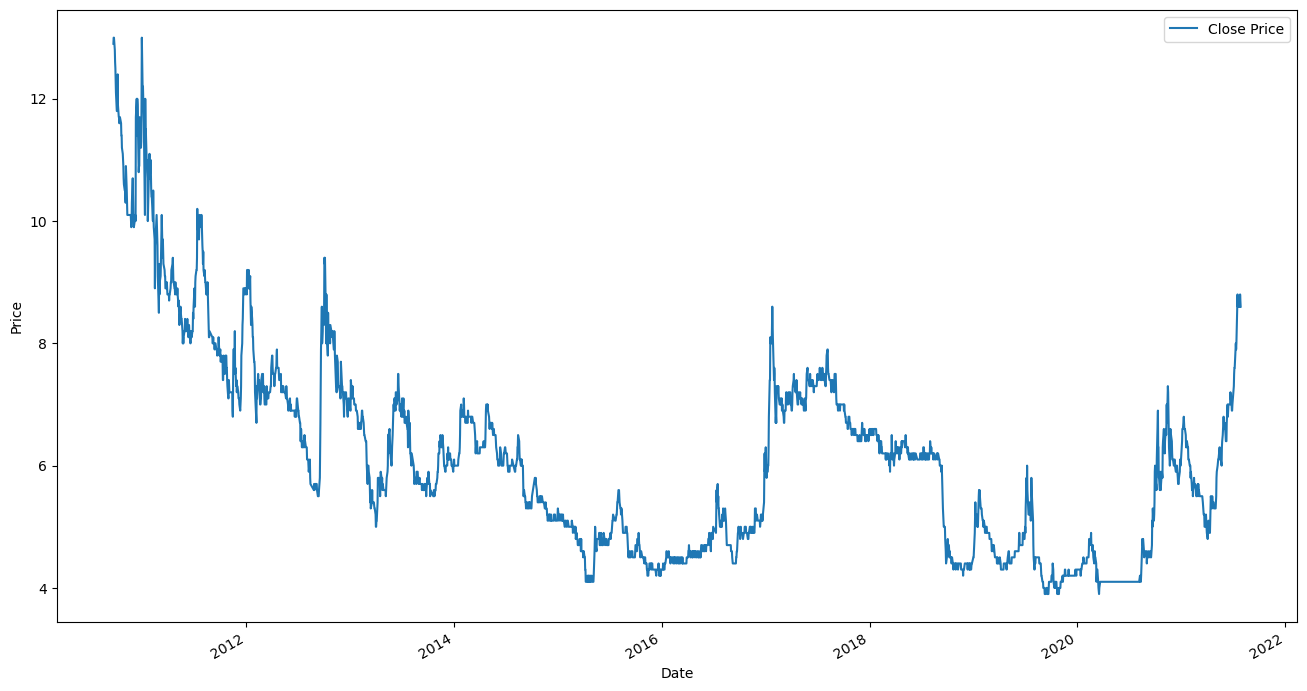

In [58]:
data['close'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Close Price'])
plt.show()

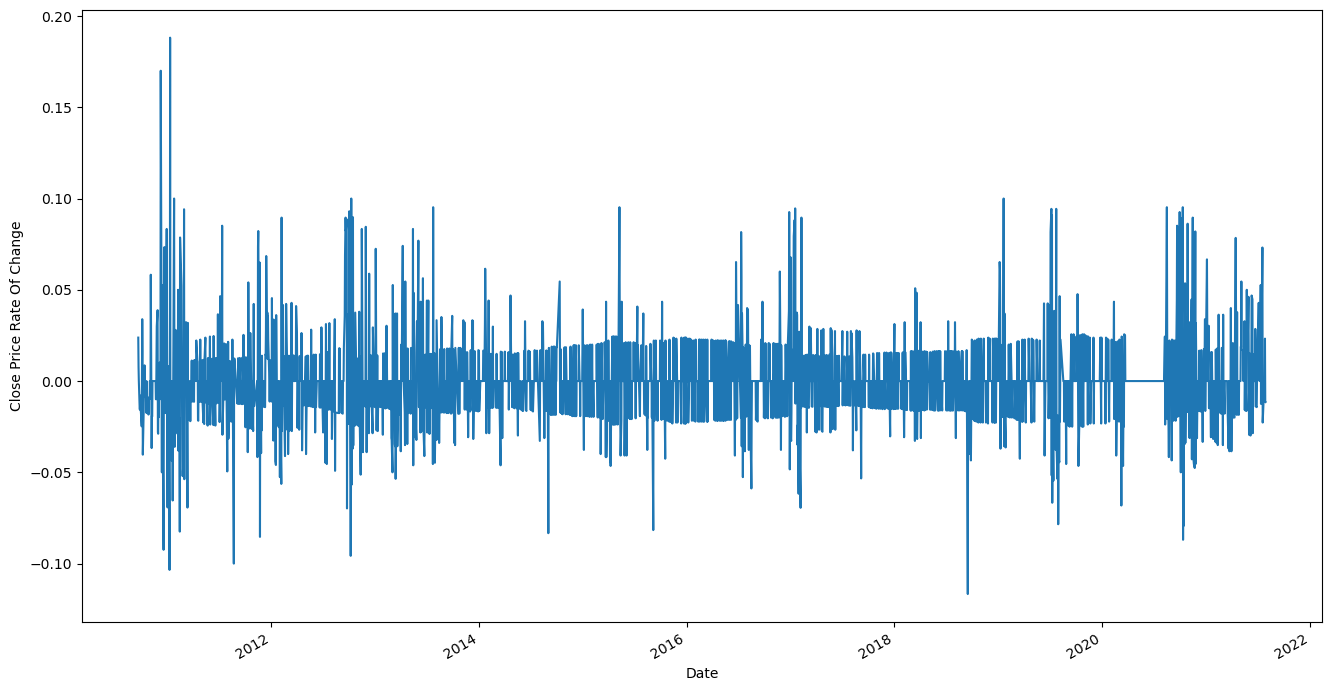

In [59]:
data['close_roc'].plot()
plt.xlabel('Date')
plt.ylabel('Close Price Rate Of Change')
plt.show()

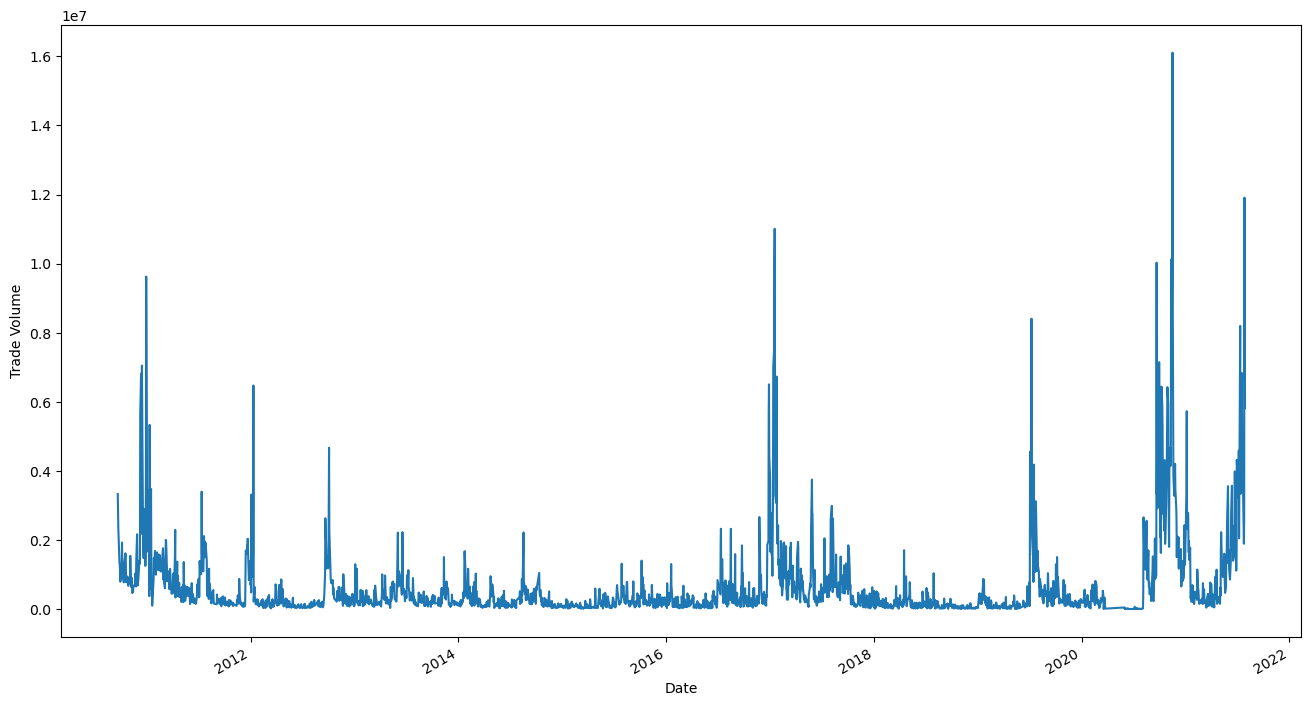

In [60]:
data['vol'].plot()
plt.xlabel('Date')
plt.ylabel('Trade Volume')
plt.show()

In [61]:
def custom_ts_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [62]:
x_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(0,1))
data_x = x_scaler.fit_transform(data)
data_y = x_scaler.fit_transform(data[['close_roc']])

In [63]:
data_x[:2], data_y[:2]

(array([[ 0.89361702,  0.85858586,  0.93406593,  0.97802198, -0.58680446,
         -0.0781963 , -0.00424251],
        [ 0.93617021,  0.8989899 ,  0.97802198,  1.        , -0.65659138,
         -0.18356606, -0.11090363]]),
 array([[-0.0781963 ],
        [-0.18356606]]))

In [64]:
data.columns

Index(['open', 'high', 'low', 'close', 'vol', 'close_roc', 'close_log_roc'], dtype='object')

In [17]:
hist_window = 48
horizon = 1
TRAIN_SPLIT = int(len(data_x)*0.8)
x_train_multi, y_train_multi = custom_ts_data_prep(data_x, data_y, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_data_prep(data_x, data_y, TRAIN_SPLIT, None, hist_window, horizon)

In [18]:
assert(x_train_multi.shape[0]  == y_train_multi.shape[0])
assert(x_val_multi.shape[0]  == y_val_multi.shape[0])

In [76]:
x_train_multi[:1], y_train_multi[:1]

(array([[[ 0.89361702,  0.85858586,  0.93406593,  0.97802198,
          -0.58680446, -0.0781963 , -0.00424251],
         [ 0.93617021,  0.8989899 ,  0.97802198,  1.        ,
          -0.65659138, -0.18356606, -0.11090363],
         [ 1.        ,  0.8989899 ,  1.        ,  1.        ,
          -0.7107942 , -0.23443422, -0.16300501],
         [ 0.93617021,  0.85858586,  0.95604396,  0.95604396,
          -0.80026302, -0.33538795, -0.26761323],
         [ 0.87234043,  0.81818182,  0.91208791,  0.91208791,
          -0.83459768, -0.33696535, -0.26926067],
         [ 0.85106383,  0.77777778,  0.89010989,  0.89010989,
          -0.83937846, -0.28651352, -0.21676701],
         [ 0.82978723,  0.73737374,  0.67032967,  0.84615385,
          -0.85961915, -0.3394261 , -0.27183148],
         [ 0.74468085,  0.6969697 ,  0.8021978 ,  0.8021978 ,
          -0.90171481, -0.34113328, -0.2736156 ],
         [ 0.80851064,  0.71717172,  0.73626374,  0.73626374,
          -0.85229276, -0.39712824, -0.332

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [21]:
lstm_model = Sequential([
    LSTM(40, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    LSTM(units=20,return_sequences=True),
    LSTM(units=15),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [22]:
model_path = r'../models/LSTM_Multivariate.h5'

In [26]:
EVALUATION_INTERVAL = 100
EPOCHS = 1
history = lstm_model.fit(train_data,
    epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data, validation_steps=50,verbose =1,
    callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
    verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min',
    verbose=0)])

100/100 [==============================] - 27s 267ms/step - loss: nan - val_loss: nan


In [27]:
# model = tf.keras.models.load_model(model_path)

In [29]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48, 40)            7680      
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 20)            4880      
_________________________________________________________________
lstm_5 (LSTM)                (None, 15)                2160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 14,736
Trainable params: 14,736
Non-trainable params: 0
_________________________________________________________________


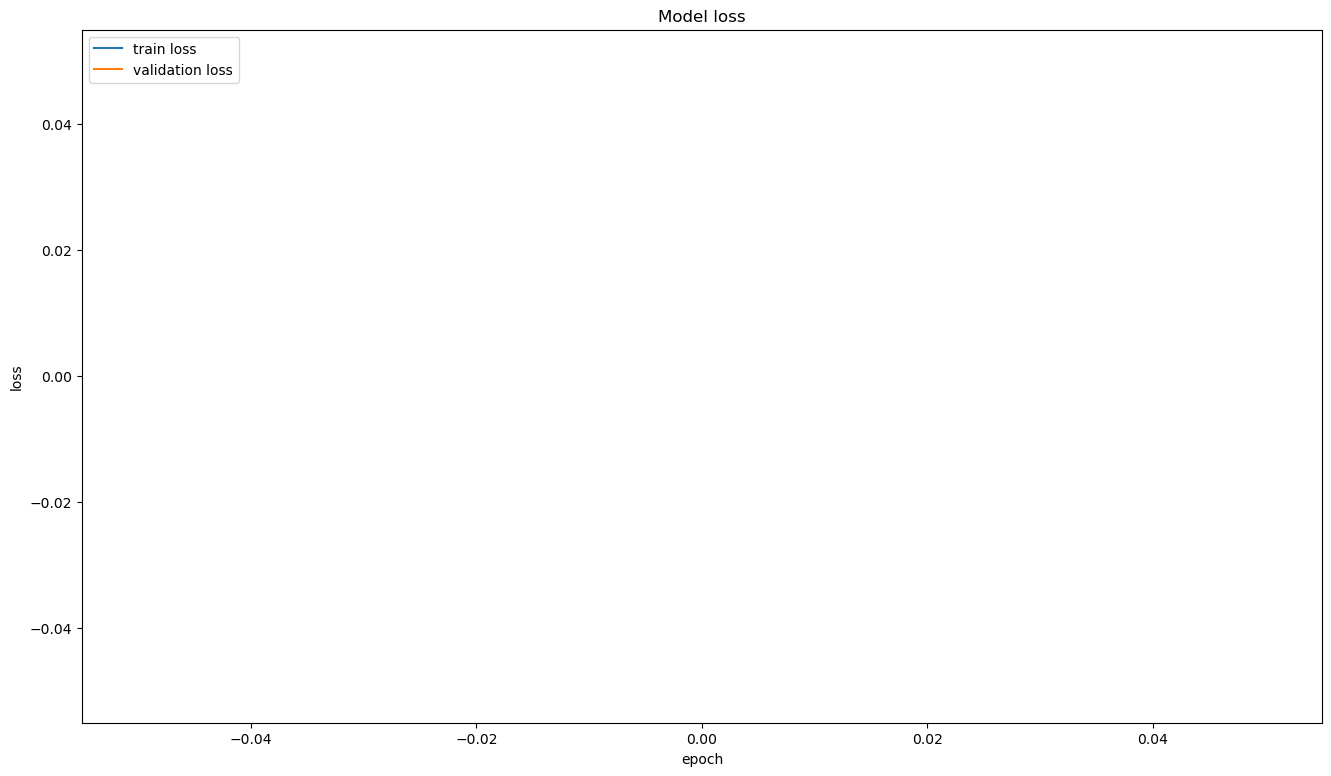

In [236]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [237]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [239]:
result_inv_trans = lstm_model.predict(x_val_multi)

In [251]:
y_val_ = [y[0][0] for y in y_val_multi]
y_pred_ = [y[0] for y in result_inv_trans]

In [252]:
timeseries_evaluation_metrics_func(y_val_, y_pred_)

Evaluation metric results:-
MSE is : 0.08113458158339956
MAE is : 0.2515039116342462
RMSE is : 0.2848413270285749
MAPE is : 100.0
R2 is : -1.6019369401871044



In [253]:
# x_ = x_train_multi.reshape(-1, 336)
# y_ = [y[0] for y in y_train_multi]

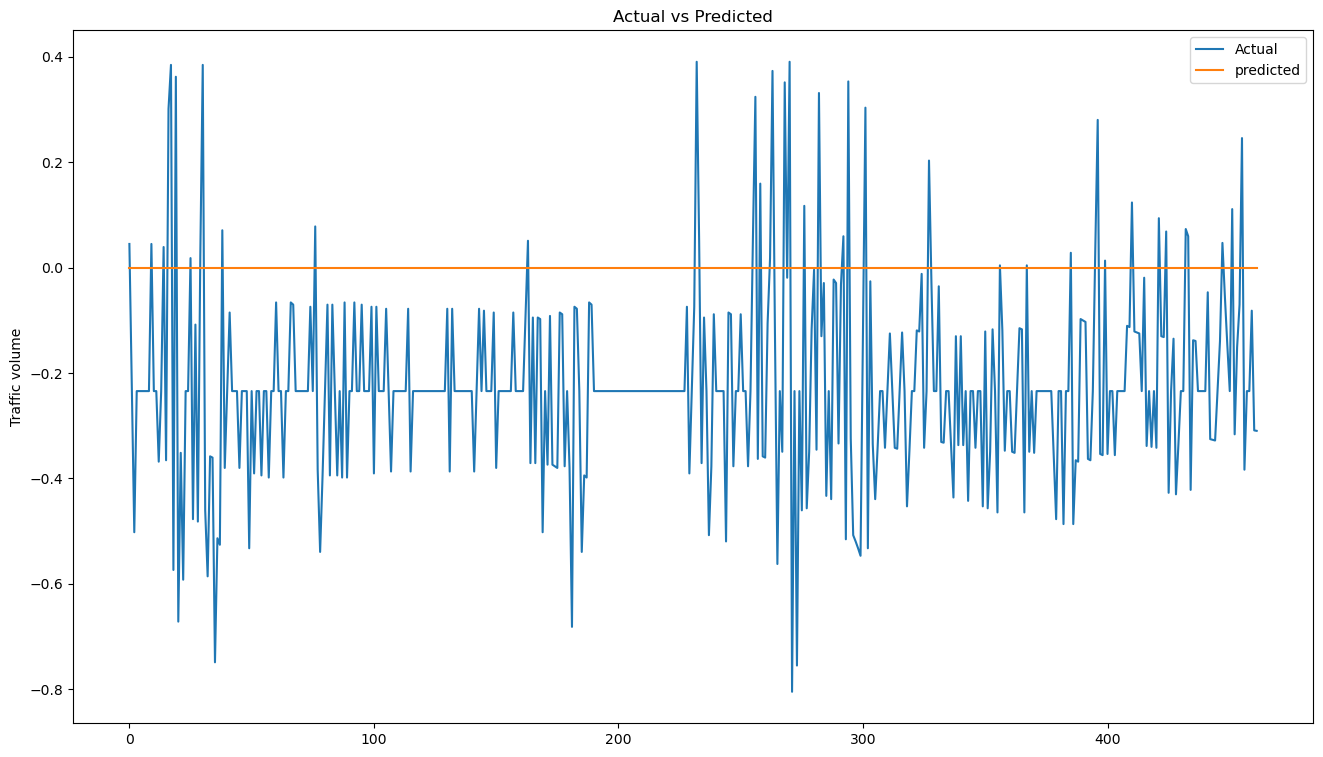

In [255]:
plt.plot( y_val_)
plt.plot( y_pred_)
plt.title("Actual vs Predicted")
plt.ylabel("Price Rate of Change")
plt.legend(('Actual','predicted'))
plt.show()